<a href="https://colab.research.google.com/github/marianagoncalvesap/ethanolbimaster/blob/main/RedesRecorrentesEtanolHidratado.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Recurrent Neural Network - LSTM


## Parte 1 - Preprocessamento de Dados

### Importar as bibliotecas

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import os

#semente inicial
seed=10
import random
np.random.seed(seed) 
random.seed(seed)
import tensorflow
tensorflow.random.set_seed(seed)

### Importar a base de dados

In [2]:
dataset_train = pd.read_csv('CEPEA_Etanol Hidratado.csv',sep=';')
training_set = dataset_train.iloc[:, 1:2].values #só coluna da série em si

### gráfico da série temporal

In [3]:
training_set[0:5,:]

array([[0.685 ],
       [0.6909],
       [0.8044],
       [0.8777],
       [0.8603]])

In [4]:
dataset_train.head()

,Data,À vista R$,À vista US$
0,28/11/2002,0.6850,0.1913
1,30/12/2002,0.6909,0.1894
2,30/01/2003,0.8044,0.2339
3,27/02/2003,0.8777,0.2443
4,28/03/2003,0.8603,0.2492


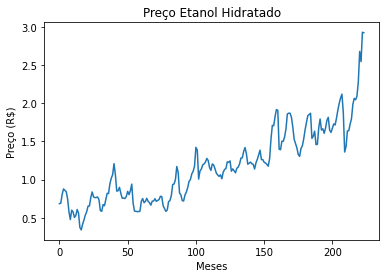

In [5]:
plt.plot(training_set)
plt.xlabel("Meses")
plt.ylabel("Preço (R$)")
plt.title("Preço Etanol Hidratado")
plt.show()

### Normalização

In [6]:
from sklearn.preprocessing import MinMaxScaler
sc = MinMaxScaler(feature_range = (0, 1))
training_set_scaled = sc.fit_transform(training_set)

### Criar a estrutura de dados com janela 10 e output 1

In [7]:
window = 10
trainSize = len(training_set_scaled)
X_train = []
y_train = []
for i in range(window, trainSize):
    X_train.append(training_set_scaled[i-window:i, 0])
    y_train.append(training_set_scaled[i, 0])
X_train, y_train = np.array(X_train), np.array(y_train)

In [8]:
X_train[0:5,:]

array([[0.13291335, 0.13519363, 0.17906006, 0.20738966, 0.20066476,
        0.19320553, 0.15668238, 0.09086342, 0.05229188, 0.09990724],
       [0.13519363, 0.17906006, 0.20738966, 0.20066476, 0.19320553,
        0.15668238, 0.09086342, 0.05229188, 0.09990724, 0.09105666],
       [0.17906006, 0.20738966, 0.20066476, 0.19320553, 0.15668238,
        0.09086342, 0.05229188, 0.09990724, 0.09105666, 0.06346139],
       [0.20738966, 0.20066476, 0.19320553, 0.15668238, 0.09086342,
        0.05229188, 0.09990724, 0.09105666, 0.06346139, 0.07215738],
       [0.20066476, 0.19320553, 0.15668238, 0.09086342, 0.05229188,
        0.09990724, 0.09105666, 0.06346139, 0.07215738, 0.10323104]])

In [9]:
y_train[0:5]

array([0.09105666, 0.06346139, 0.07215738, 0.10323104, 0.08502744])

In [10]:
from sklearn.model_selection import  train_test_split
input_train,input_test,output_train,output_test = train_test_split(X_train,y_train,test_size=0.2)

### Reshaping

In [11]:
input_train.shape

(171, 10)

In [12]:
input_train = np.reshape(input_train, (input_train.shape[0], input_train.shape[1], 1))

In [13]:
input_train.shape

(171, 10, 1)

## Parte 2 - Construção da RNN

### Bibliotecas necessárias

In [14]:
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout

### Construção da Rede completa

In [15]:
# Initicializar a RNN
regressor = Sequential()
 
# Adicionar a primeira camada LSTM e Dropout 
regressor.add(LSTM(units = 100, return_sequences = True, input_shape = (input_train.shape[1], 1)))
regressor.add(Dropout(0.2))
 
# Adicionar a segunda camada LSTM e Dropout
regressor.add(LSTM(units = 80, return_sequences = True))
regressor.add(Dropout(0.2))
 
# Adicionar a terceira camada LSTM e Dropout
regressor.add(LSTM(units = 50))
regressor.add(Dropout(0.2))
 
# camada de saída
regressor.add(Dense(units = 1))
 
# Compilar a rede
regressor.compile(optimizer = 'adam', loss = 'mean_squared_error')

# Visualizar a rede
regressor.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 10, 100)           40800     
                                                                 
 dropout (Dropout)           (None, 10, 100)           0         
                                                                 
 lstm_1 (LSTM)               (None, 10, 80)            57920     
                                                                 
 dropout_1 (Dropout)         (None, 10, 80)            0         
                                                                 
 lstm_2 (LSTM)               (None, 50)                26200     
                                                                 
 dropout_2 (Dropout)         (None, 50)                0         
                                                                 
 dense (Dense)               (None, 1)                 5

### Treinamento

In [16]:
from keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
es = EarlyStopping(patience=50)
rlr = ReduceLROnPlateau(monitor='val_loss', patience=30)
mc = ModelCheckpoint(filepath='best.h5', save_best_only=True) # se quiser manter um tracking da época e do erro: 'best_{epoch:03d}-{val_loss:.4f}.h5'

history = regressor.fit(input_train, output_train, epochs = 250, batch_size = 32, validation_split=0.1, callbacks=[rlr, es, mc])

Epoch 1/250
5/5 [==============================] - 7s 384ms/step - loss: 0.1040 - val_loss: 0.0292 - lr: 0.0010
Epoch 2/250
5/5 [==============================] - 0s 37ms/step - loss: 0.0266 - val_loss: 0.0236 - lr: 0.0010
Epoch 3/250
5/5 [==============================] - 0s 36ms/step - loss: 0.0212 - val_loss: 0.0130 - lr: 0.0010
Epoch 4/250
5/5 [==============================] - 0s 29ms/step - loss: 0.0187 - val_loss: 0.0141 - lr: 0.0010
Epoch 5/250
5/5 [==============================] - 0s 36ms/step - loss: 0.0135 - val_loss: 0.0083 - lr: 0.0010
Epoch 6/250
5/5 [==============================] - 0s 29ms/step - loss: 0.0135 - val_loss: 0.0084 - lr: 0.0010
Epoch 7/250
5/5 [==============================] - 0s 28ms/step - loss: 0.0109 - val_loss: 0.0084 - lr: 0.0010
Epoch 8/250
5/5 [==============================] - 0s 40ms/step - loss: 0.0112 - val_loss: 0.0076 - lr: 0.0010
Epoch 9/250
5/5 [==============================] - 0s 35ms/step - loss: 0.0091 - val_loss: 0.0058 - lr: 0.0010


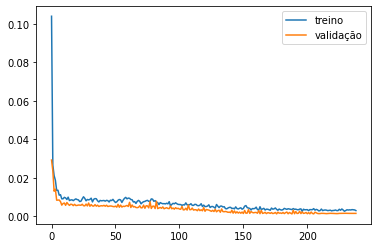

In [17]:
plt.plot(history.history['loss'], label='treino')
plt.plot(history.history['val_loss'], label='validação')
plt.legend();

## Parte 3 - Fazer as previsões e analisar os resultados

### Fazer as previsões

In [18]:
input_test.shape

(43, 10)

In [19]:
input_test = np.reshape(input_test, (input_test.shape[0], input_test.shape[1], 1))

In [20]:
input_test.shape

(43, 10, 1)

In [21]:
regressor.load_weights('best.h5')
predicted_hydrous_price = regressor.predict(input_test)
predicted_hydrous_price = sc.inverse_transform(predicted_hydrous_price)

### Visualizar os resultados de treino e teste

In [22]:
predicted_train = regressor.predict(input_train)
predicted_train = sc.inverse_transform(predicted_train)

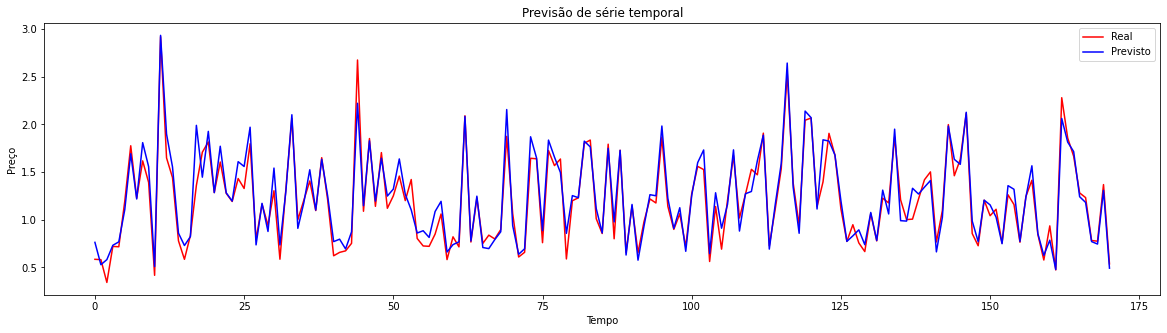

In [23]:
plt.figure(figsize=(20,5))
output_train_denorm = sc.inverse_transform(np.reshape(output_train, (output_train.shape[0], 1)))
plt.plot(output_train_denorm, color = 'red', label = 'Real')
plt.plot(predicted_train, color = 'blue', label = 'Previsto')
plt.title('Previsão de série temporal')
plt.xlabel('Tempo')
plt.ylabel('Preço')
plt.legend()
plt.savefig('predictions_training_test.svg')
plt.show()

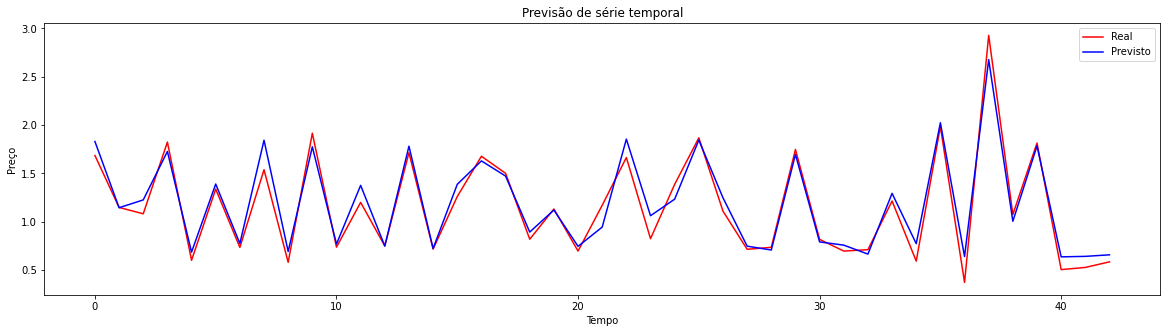

In [24]:
plt.figure(figsize=(20,5))
output_test_denorm = sc.inverse_transform(np.reshape(output_test, (output_test.shape[0], 1)))
plt.plot(output_test_denorm, color = 'red', label = 'Real')
plt.plot(predicted_hydrous_price, color = 'blue', label = 'Previsto')
plt.title('Previsão de série temporal')
plt.xlabel('Tempo')
plt.ylabel('Preço')
plt.legend()
plt.savefig('predictions_training_test.svg')
plt.show()

## Parte 4 - Métricas de avaliação

In [25]:
import math
from sklearn.metrics import mean_squared_error
rmse = math.sqrt(mean_squared_error(output_test_denorm, predicted_hydrous_price))
print('RMSE: ', rmse)

RMSE:  0.12447536353190991


In [26]:
mse = mean_squared_error(output_test_denorm, predicted_hydrous_price)
print('MSE: ',mse)

MSE:  0.015494116126401128


In [27]:
mape = np.mean(np.abs((output_test_denorm - predicted_hydrous_price) / output_test_denorm)) * 100
print('MAPE: ',mape, '%')

MAPE:  10.569350179064738 %


In [28]:
from sklearn.metrics import r2_score
print('R2: ', r2_score(output_test_denorm, predicted_hydrous_price[:,0]))

R2:  0.946275837398085


Prever o valor de preços é uma tarefa muito difícil. Hoje melhores resultados são obtidos com a utilização de dados de redes sociais e jornais para analisar o sentimento do mercado, a política, economia, etc.